In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from pycbc.types import timeseries
from calcwf import gen_wf, chirp2total, total2chirp, match_h1_h2, match_hn, get_h, match_s_f_max, match_true_anomaly

In [2]:
sample_rate = 4096

In [3]:
def const_eff_chirp(given_e, given_chirp, e_vals):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Fawata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-157*given_e**2/24)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-157*e_vals**2/24)**(3/5)

    return chirp_vals

# e^2 against chirp mass plot functions

In [4]:
# Calculates matches to a fiducial h1, h2 waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match(e_vals, chirp_vals, n, fiducials, f_low, approximant='TEOBResumS', max_method=None):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'diff_phase':[], 'quad':[]}
    for i in range(n):
            matches[f'h{i+1}'] = []
            matches[f'h{i+1}_phase'] = []
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Generate fiducial waveform
    all_wfs = list(get_h([1]*n, f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant))
    wf_hjs = all_wfs[1:n+1]

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        for i in range(n):
            matches[f'h{i+1}'].append([])
            matches[f'h{i+1}_phase'].append([])
        matches['diff_phase'].append([])
        matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate h1, h2 matches
            if max_method == None:
                s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
                match_cplx = match_hn(wf_hjs, s, f_low)
            else:
                match_cplx = match_s_f_max(wf_hjs[0], wf_hjs[1], f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant, max_method=max_method)

            # Save matches
            match_quad_sqrd = 0
            for i in range(n):
                matches[f'h{i+1}'][-1].append(abs(match_cplx[i]))
                matches[f'h{i+1}_phase'][-1].append(np.angle(match_cplx[i]))
                match_quad_sqrd += abs(match_cplx[i])**2
            matches['diff_phase'][-1].append(np.angle(match_cplx[0]) - np.angle(match_cplx[1]))
            matches['quad'][-1].append(np.sqrt(match_quad_sqrd))

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [5]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot(e_vals, chirp_vals, n, fiducials, matches, vmins=[0.7,0.7,0.7,0.7], vmaxs=[1,1,1,1]):
    
    # Convert to eccentricity squared
    e2_vals = e_vals**2

    # Make contour plot for  each match
    keys = [f'h{i+1}' for i in range(n)]
    keys.append('quad')
    for i, key in enumerate(keys):

        # Which direction colorbar extends
        if [vmins[i], vmaxs[i]] == [0,1]:
            extend = 'neither'
        elif vmins[i] == 0:
            extend = 'max'
        elif vmaxs[i] == 1:
            extend = 'min'
        else:
            extend = 'both'

        # Plotting amplitude contours
        plt.contourf(chirp_vals, e2_vals, matches[key], np.linspace(vmins[i], vmaxs[i], 15), vmin=vmins[i], vmax=vmaxs[i], extend=extend)
        plt.colorbar(label='match')
        if key == 'h1' or key == 'quad':
            plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])
        else:
            plt.contour(chirp_vals, e2_vals, matches['h1'], [0.97], colors=['C1'])
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        #plt.plot(const_eff_chirp(fiducials[0], fiducials[1], e2_vals**0.5), e2_vals, c='k', ls='dashed', alpha=0.7)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

    # Plot h2/h1 ratio contours
    if vmins[-1] == 0:
        extend = 'max'
    else:
        extend = 'both'
    plt.contourf(chirp_vals, e2_vals, np.array(matches['h2'])/np.array(matches['h1']), np.linspace(vmins[-1], vmaxs[-1], 15), vmin=vmins[-1], vmax=vmaxs[-1], extend=extend)
    plt.colorbar(label='match ratio')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'h2/h1, q={fiducials[2]}')
    plt.show()

    # Make contour plot for phase of each match
    keys = [f'h{i+1}_phase' for i in range(n)]
    keys.append('diff_phase')
    for i, key in enumerate(keys):

        # phase
        plt.contourf(chirp_vals, e2_vals, matches[key], cmap='twilight_shifted')
        plt.colorbar(label='phase of complex overlap')
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

        # cos(phase)
        plt.contourf(chirp_vals, e2_vals, np.cos(matches[key]))
        plt.colorbar(label='cos(phase) of complex overlap')
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key} (cos), q={fiducials[2]}')
        plt.show()

In [6]:
# Calculates matches to a fiducial waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match_ta(e_vals, chirp_vals, n, fiducials, f_low, approximant='TEOBResumS', final_match='quad'):

    # Setup match dict and calculate conversion from chirp to total mass
    if final_match == 'TEOB':
        matches = {'match_amp':[], 'match_phase':[]}
    elif final_match == 'quad':
        matches = {'diff_phase':[], 'quad':[]}
        for i in range(n):
                matches[f'h{i+1}'] = []
                matches[f'h{i+1}_phase'] = []
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        if final_match == 'TEOB':
            matches['match_amp'].append([])
            matches['match_phase'].append([])
        elif final_match == 'quad':
            for i in range(n):
                matches[f'h{i+1}'].append([])
                matches[f'h{i+1}_phase'].append([])
            matches['diff_phase'].append([])
            matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate h1, h2 matches
            s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
            match_cplx = match_true_anomaly(s, n, f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant, final_match)

            # Save matches
            if final_match == 'TEOB':
                matches['match_amp'][-1].append(abs(match_cplx))
                matches['match_phase'][-1].append(np.angle(match_cplx))
            elif final_match == 'quad':
                match_quad_sqrd = 0
                for i in range(n):
                    matches[f'h{i+1}'][-1].append(abs(match_cplx[i]))
                    matches[f'h{i+1}_phase'][-1].append(np.angle(match_cplx[i]))
                    match_quad_sqrd += abs(match_cplx[i])**2
                matches['diff_phase'][-1].append(np.angle(match_cplx[0]) - np.angle(match_cplx[1]))
                matches['quad'][-1].append(np.sqrt(match_quad_sqrd))

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [7]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot_ta(e_vals, chirp_vals, fiducials, matches, vmin=0.7, vmax=1):
    
    # Convert to eccentricity squared
    e2_vals = e_vals**2

    # Which direction colorbar extends
    if [vmin, vmax] == [0,1]:
        extend = 'neither'
    elif vmin == 0:
        extend = 'max'
    elif vmax == 1:
        extend = 'min'
    else:
        extend = 'both'

    # Plotting amplitude contours
    plt.contourf(chirp_vals, e2_vals, matches['match_amp'], np.linspace(vmin, vmax, 15), vmin=vmin, vmax=vmax, extend=extend)
    plt.colorbar(label='match')
    plt.contour(chirp_vals, e2_vals, matches['match_amp'], [0.97], colors=['C1'])
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'Match amplitude, q={fiducials[2]}')
    plt.show()

    # Phase plot
    plt.contourf(chirp_vals, e2_vals, matches['match_phase'], cmap='twilight_shifted')
    plt.colorbar(label='phase of match')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'Match phase, q={fiducials[2]}')
    plt.show()

    # Cosine of phase plot
    plt.contourf(chirp_vals, e2_vals, np.cos(matches['match_phase']))
    plt.colorbar(label='cos(phase) of complex overlap')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'Match cos(phase), q={fiducials[2]}')
    plt.show()

In [8]:
# Calculates matches to a fiducial h1, h2 waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match_svd(e_vals, chirp_vals, SVD_name, fiducials, f_low, approximant='TEOBResumS'):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'h1':[], 'h1_phase':[], 'h2':[], 'h2_phase':[], 'diff_phase':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Load SVD waveforms as fiducial waveforms (note epoch unimportant for match_h1_h2)
    with open(os.path.join('SVD_waveforms', SVD_name), 'rb') as fp:
        SVD_wfs = pickle.load(fp)
    h1 = timeseries.TimeSeries(SVD_wfs[0], 1/sample_rate, epoch=0)
    h2 = timeseries.TimeSeries(SVD_wfs[1], 1/sample_rate, epoch=0)

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['h1'].append([])
        matches['h1_phase'].append([])
        matches['h2'].append([])
        matches['h2_phase'].append([])
        matches['diff_phase'].append([])
        matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate h1, h2 matches
            s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
            match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)

            # Save matches
            matches['h1'][-1].append(abs(match_h1))
            matches['h1_phase'][-1].append(np.angle(match_h1))
            matches['h2'][-1].append(abs(match_h2))
            matches['h2_phase'][-1].append(np.angle(match_h2))
            matches['diff_phase'][-1].append(np.angle(match_h1) - np.angle(match_h2))
            match_quad = np.sqrt(abs(match_h1)**2+abs(match_h2**2))
            matches['quad'][-1].append(match_quad)

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

# Saving/loading data functions

In [9]:
# Save data as pickle
def save_dataslot(data, no):
    with open(os.path.join('e_sqrd_chirp_data', f'dataslot_{no}'), 'wb') as fp:
        pickle.dump(data, fp)

# Load data as pickle
def load_dataslot(no):
    with open(os.path.join('e_sqrd_chirp_data', f'dataslot_{no}'), 'rb') as fp:
        data = pickle.load(fp)
    return data

# $e_{10}=0.1, \mathcal{M}=24~M_\odot, q=2$

## No maximisation over shifted frequencies (1 TEOB call per grid point)

In [ ]:
e_vals_0 = np.linspace(0, 0.2, 31)
chirp_vals_0 = np.linspace(23, 25, 31)
start = time.time()
dataslot_0 = ecc_chirp_match(e_vals_0, chirp_vals_0, 2, [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_0, 0)

In [ ]:
dataslot_0 = load_dataslot(0)
ecc_chirp_plot(e_vals_0, chirp_vals_0, 2, [0.1, 24, 2], dataslot_0, vmins=[0.8,0,0.8,0], vmaxs=[1,0.2,1,0.2])

## Maximisation over shifted frequencies with the phase difference method (2 TEOB calls per grid point)

In [ ]:
e_vals_1 = np.linspace(0, 0.2, 31)
chirp_vals_1 = np.linspace(23, 25, 31)
start = time.time()
dataslot_1 = ecc_chirp_match(e_vals_1, chirp_vals_1, 2, [0.1, 24, 2], 10, max_method='phase_diff')
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_1, 1)

In [ ]:
dataslot_1 = load_dataslot(1)
ecc_chirp_plot(e_vals_1, chirp_vals_1, 2, [0.1, 24, 2], dataslot_1, vmins=[0.8,0,0.8,0], vmaxs=[1,0.2,1,0.2])

## Maximisation over shifted frequencies with the sine approximation method (4 TEOB calls per grid point)

In [ ]:
e_vals_2 = np.linspace(0, 0.2, 31)
chirp_vals_2 = np.linspace(23, 25, 31)
start = time.time()
dataslot_2 = ecc_chirp_match(e_vals_2, chirp_vals_2, 2, [0.1, 24, 2], 10, max_method='sine_approx')
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_2, 2)

In [ ]:
dataslot_2 = load_dataslot(2)
ecc_chirp_plot(e_vals_2, chirp_vals_2, 2, [0.1, 24, 2], dataslot_2, vmins=[0.8,0,0.8,0], vmaxs=[1,0.2,1,0.2])

## Phase diff method, shifting h1/h2, final match TEOB (4 TEOB calls per gridpoint)

In [ ]:
e_vals_3 = np.linspace(0, 0.2, 31)
chirp_vals_3 = np.linspace(23, 25, 31)
start = time.time()
dataslot_3 = ecc_chirp_match_ta(e_vals_3, chirp_vals_3, 2, [0.1, 24, 2], 10, final_match='TEOB')
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_3, 3)

In [ ]:
dataslot_3 = load_dataslot(3)
ecc_chirp_plot_ta(e_vals_3, chirp_vals_3, [0.1, 24, 2], dataslot_3, vmin=0.8, vmax=1)

## Phase diff method, shifting h1/h2, final match quad (6 TEOB calls per gridpoint)

In [ ]:
e_vals_4 = np.linspace(0, 0.2, 31)
chirp_vals_4 = np.linspace(23, 25, 31)
start = time.time()
dataslot_4 = ecc_chirp_match_ta(e_vals_4, chirp_vals_4, 2, [0.1, 24, 2], 10, final_match='quad')
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_4, 4)

In [ ]:
dataslot_4 = load_dataslot(4)
ecc_chirp_plot(e_vals_4, chirp_vals_4, 2, [0.1, 24, 2], dataslot_4, vmins=[0.8,0,0.8,0], vmaxs=[1,0.4,1,0.2])

## Using 2 SVD waveforms generated with 100 training waveforms

In [ ]:
e_vals_5 = np.linspace(0, 0.2, 31)
chirp_vals_5 = np.linspace(23, 25, 31)
start = time.time()
dataslot_5 = ecc_chirp_match_svd(e_vals_5, chirp_vals_5, 'U_matrix_2svd_100t.pkl', [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_5, 5)

In [ ]:
dataslot_5 = load_dataslot(5)
ecc_chirp_plot(e_vals_5, chirp_vals_5, 2, [0.1, 24, 2], dataslot_5, vmins=[0.8,0,0.8,0], vmaxs=[1,0.4,1.001,0.5])

## No maximisation over shifted frequencies, n=3 (5 TEOB calls per gridpoint)

In [10]:
e_vals_6 = np.linspace(0, 0.2, 31)
chirp_vals_6 = np.linspace(23, 25, 31)
start = time.time()
dataslot_6 = ecc_chirp_match(e_vals_6, chirp_vals_6, 3, [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_6, 6)

961 done out of 961
Time taken: 1492.818302154541 seconds


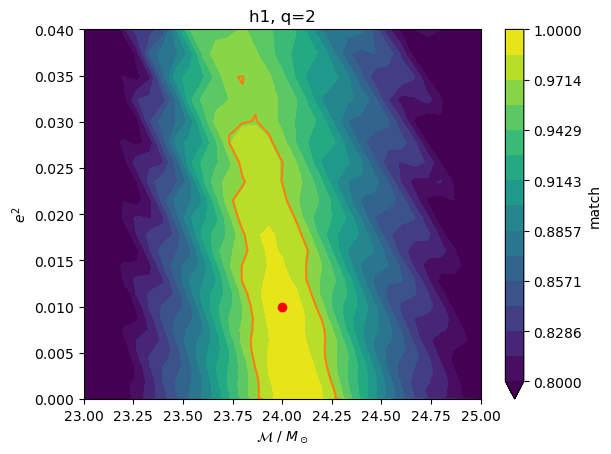

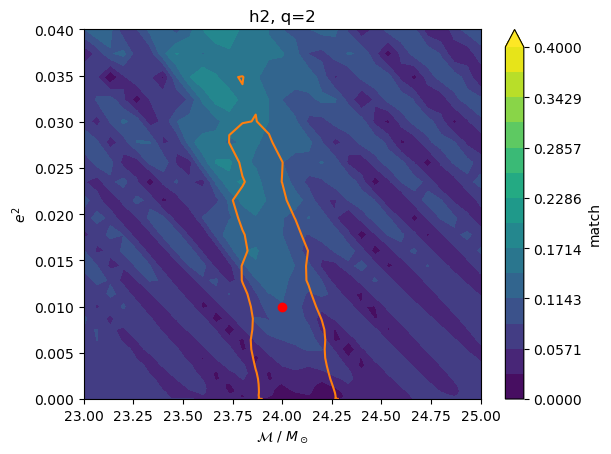

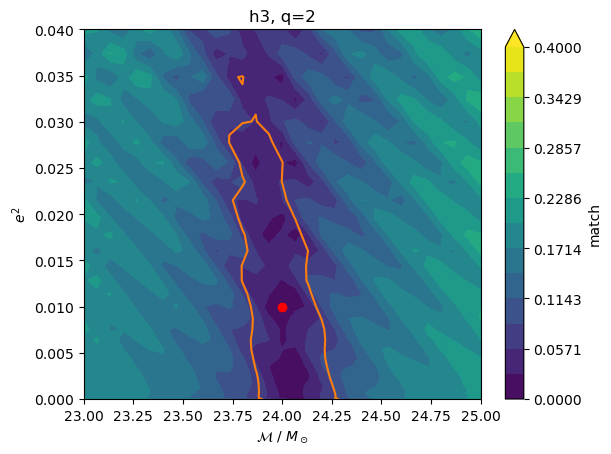

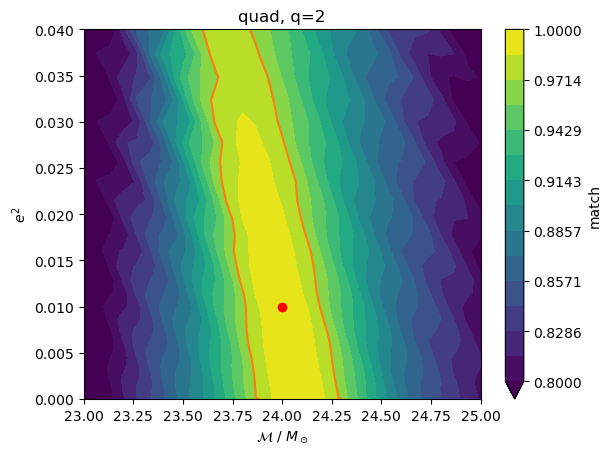

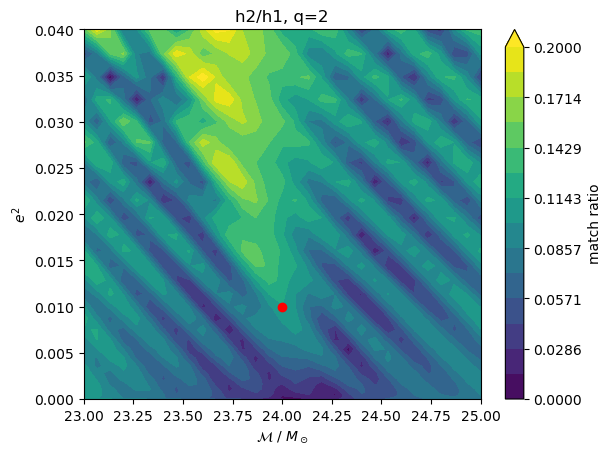

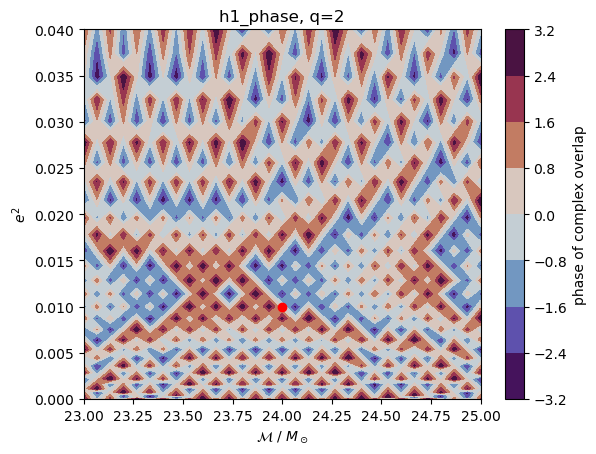

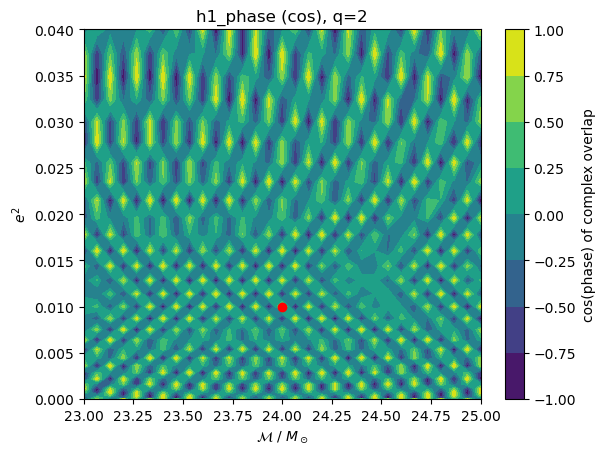

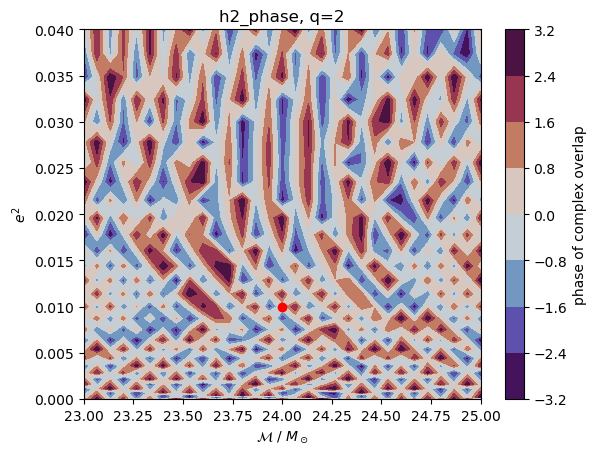

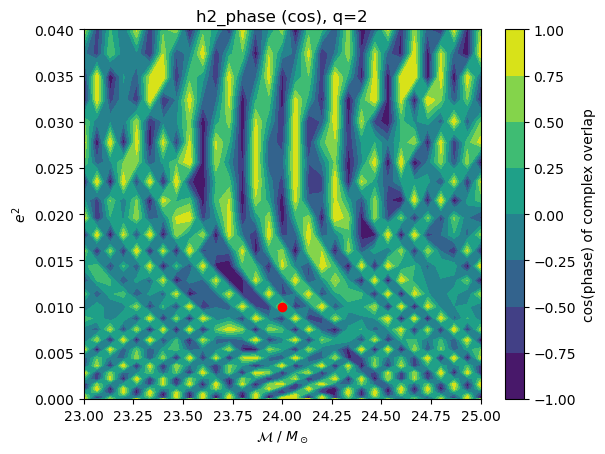

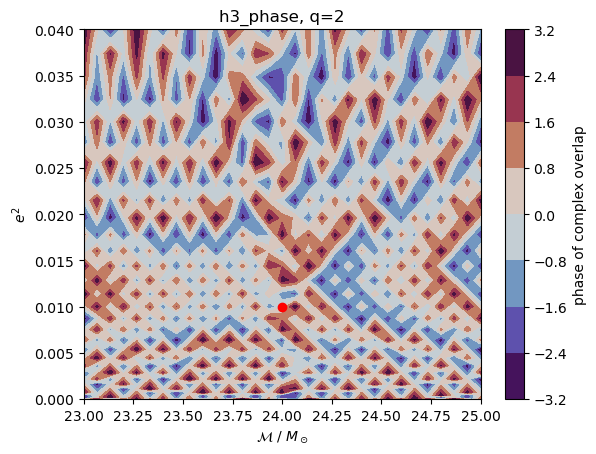

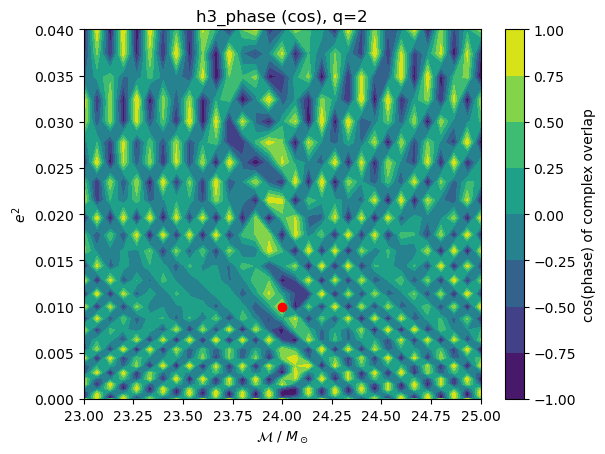

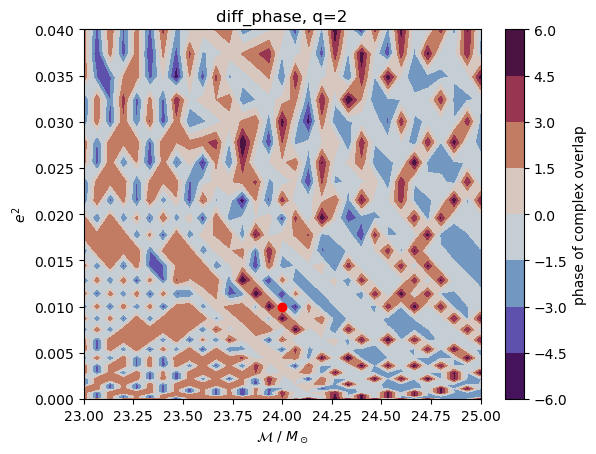

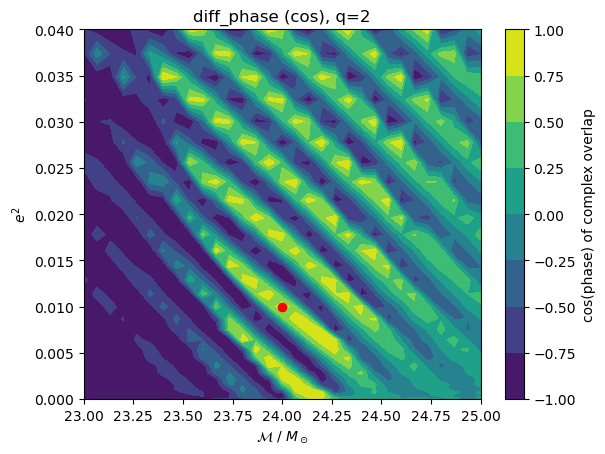

In [11]:
dataslot_6 = load_dataslot(6)
ecc_chirp_plot(e_vals_6, chirp_vals_6, 3, [0.1, 24, 2], dataslot_6, vmins=[0.8,0,0,0.8,0], vmaxs=[1,0.4,0.4,1,0.2])

## Phase diff method, shifting h1/h2, final match quad, n=3 (10 TEOB calls per gridpoint)

In [12]:
e_vals_7 = np.linspace(0, 0.2, 31)
chirp_vals_7 = np.linspace(23, 25, 31)
start = time.time()
dataslot_7 = ecc_chirp_match_ta(e_vals_7, chirp_vals_7, 3, [0.1, 24, 2], 10, final_match='quad')
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_7, 7)

961 done out of 961
Time taken: 15628.866134643555 seconds


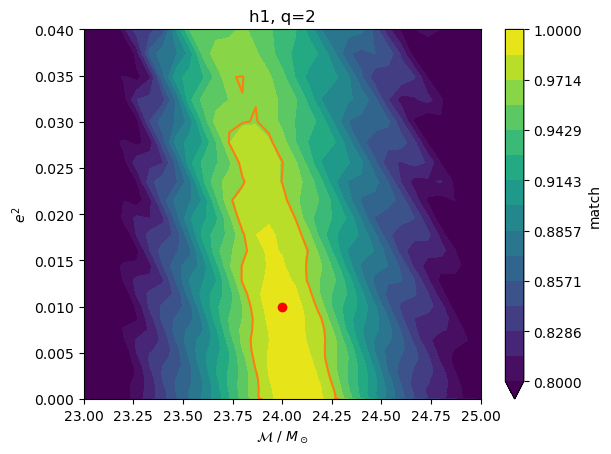

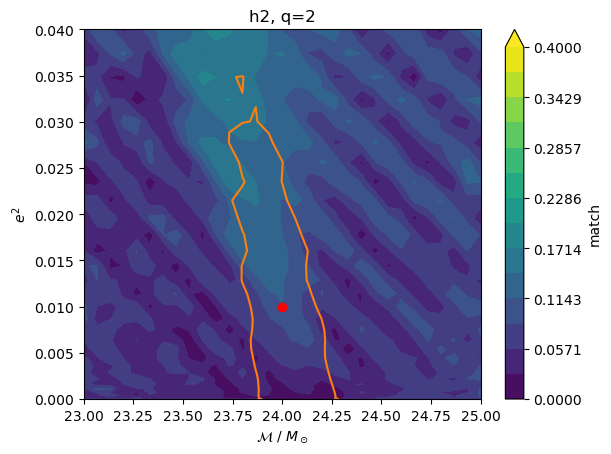

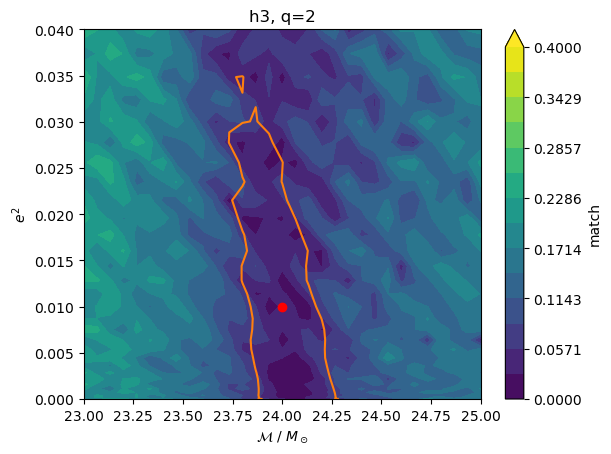

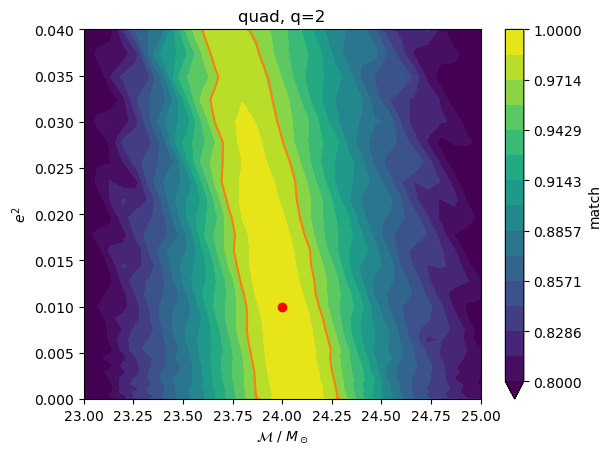

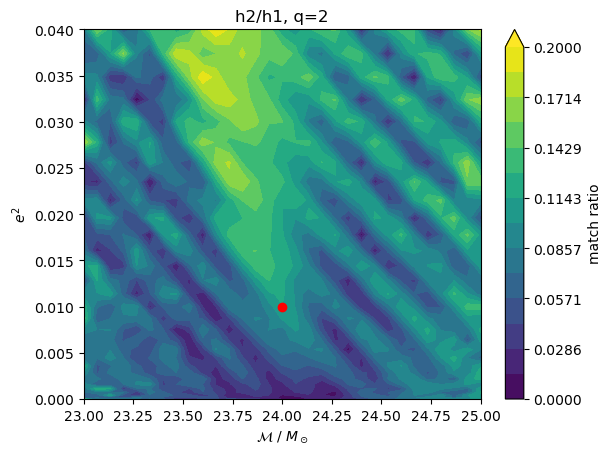

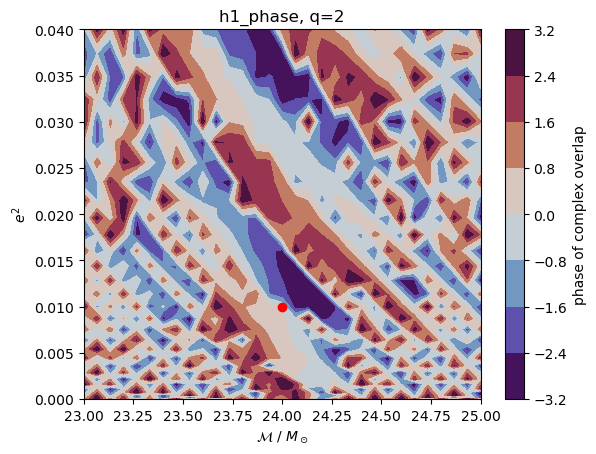

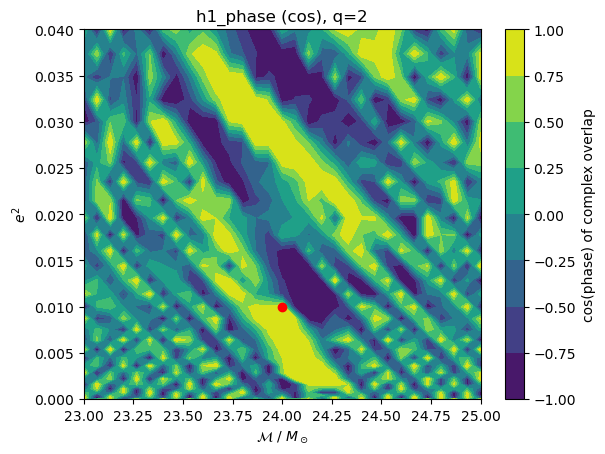

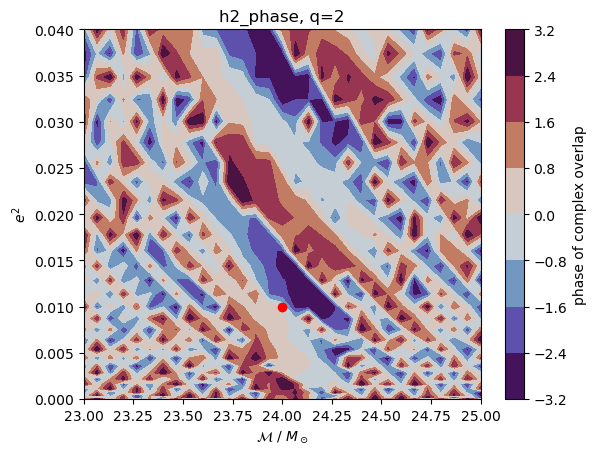

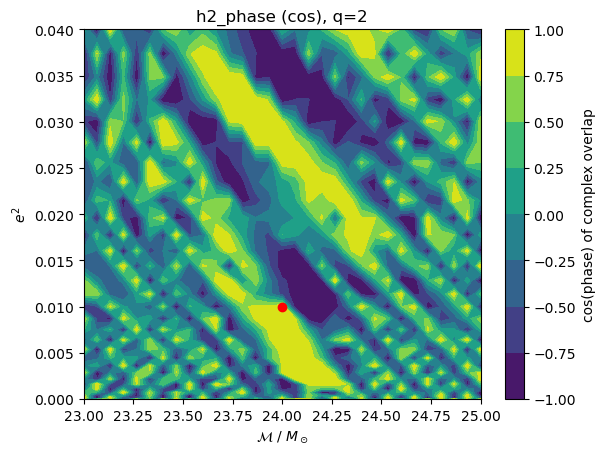

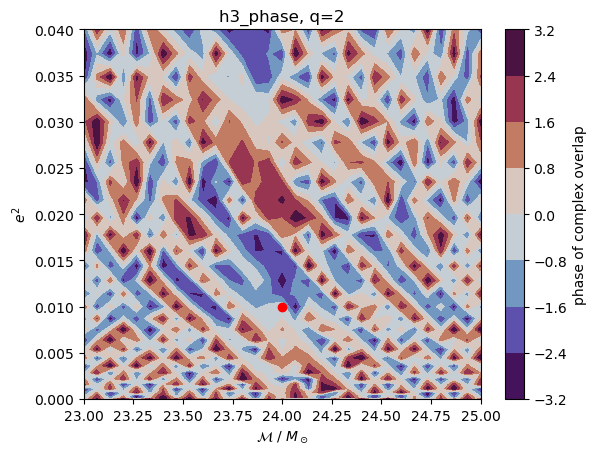

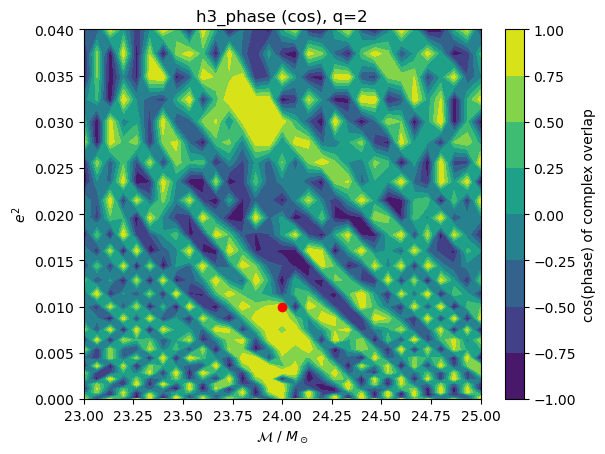

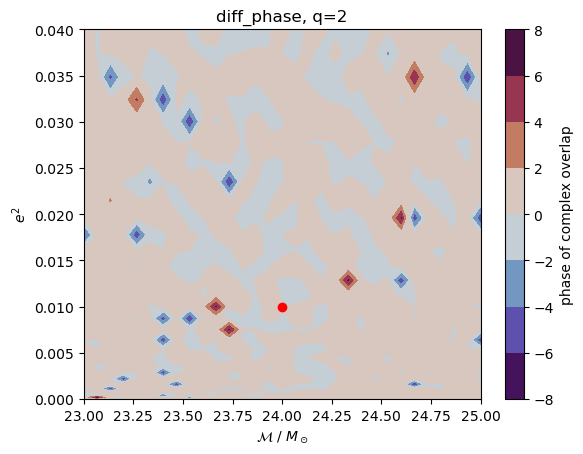

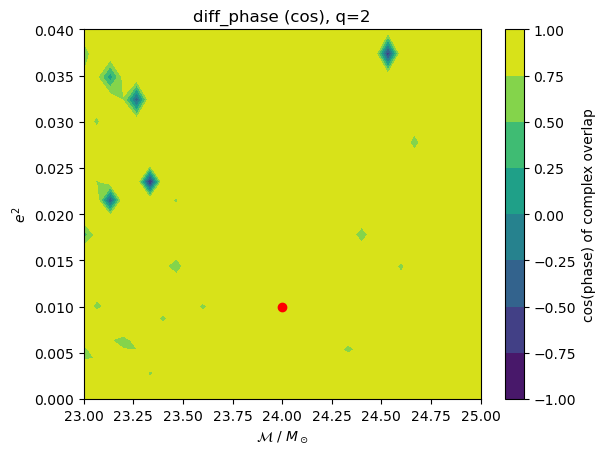

In [13]:
dataslot_7 = load_dataslot(7)
ecc_chirp_plot(e_vals_7, chirp_vals_7, 3, [0.1, 24, 2], dataslot_7, vmins=[0.8,0,0,0.8,0], vmaxs=[1,0.4,0.4,1,0.2])

## No maximisation over shifted frequencies, n=4 (7 TEOB calls per gridpoint)

In [ ]:
e_vals_8 = np.linspace(0, 0.2, 31)
chirp_vals_8 = np.linspace(23, 25, 31)
start = time.time()
dataslot_8 = ecc_chirp_match(e_vals_8, chirp_vals_8, 4, [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_8, 8)

620 done out of 961

In [ ]:
dataslot_8 = load_dataslot(8)
ecc_chirp_plot(e_vals_8, chirp_vals_8, 4, [0.1, 24, 2], dataslot_8, vmins=[0.8,0,0,0,0.8,0], vmaxs=[1,0.4,0.4,0.4,1,0.2])

## Phase diff method, shifting h1/h2, final match quad, n=4 (14 TEOB calls per gridpoint)

In [ ]:
e_vals_9 = np.linspace(0, 0.2, 31)
chirp_vals_9 = np.linspace(23, 25, 31)
start = time.time()
dataslot_9 = ecc_chirp_match_ta(e_vals_9, chirp_vals_9, 4, [0.1, 24, 2], 10, final_match='quad')
end = time.time()
print(f'\nTime taken: {end-start} seconds')
save_dataslot(dataslot_9, 9)

In [ ]:
dataslot_9 = load_dataslot(9)
ecc_chirp_plot(e_vals_9, chirp_vals_9, 4, [0.1, 24, 2], dataslot_9, vmins=[0.8,0,0,0,0.8,0], vmaxs=[1,0.4,0.4,0.4,1,0.2])